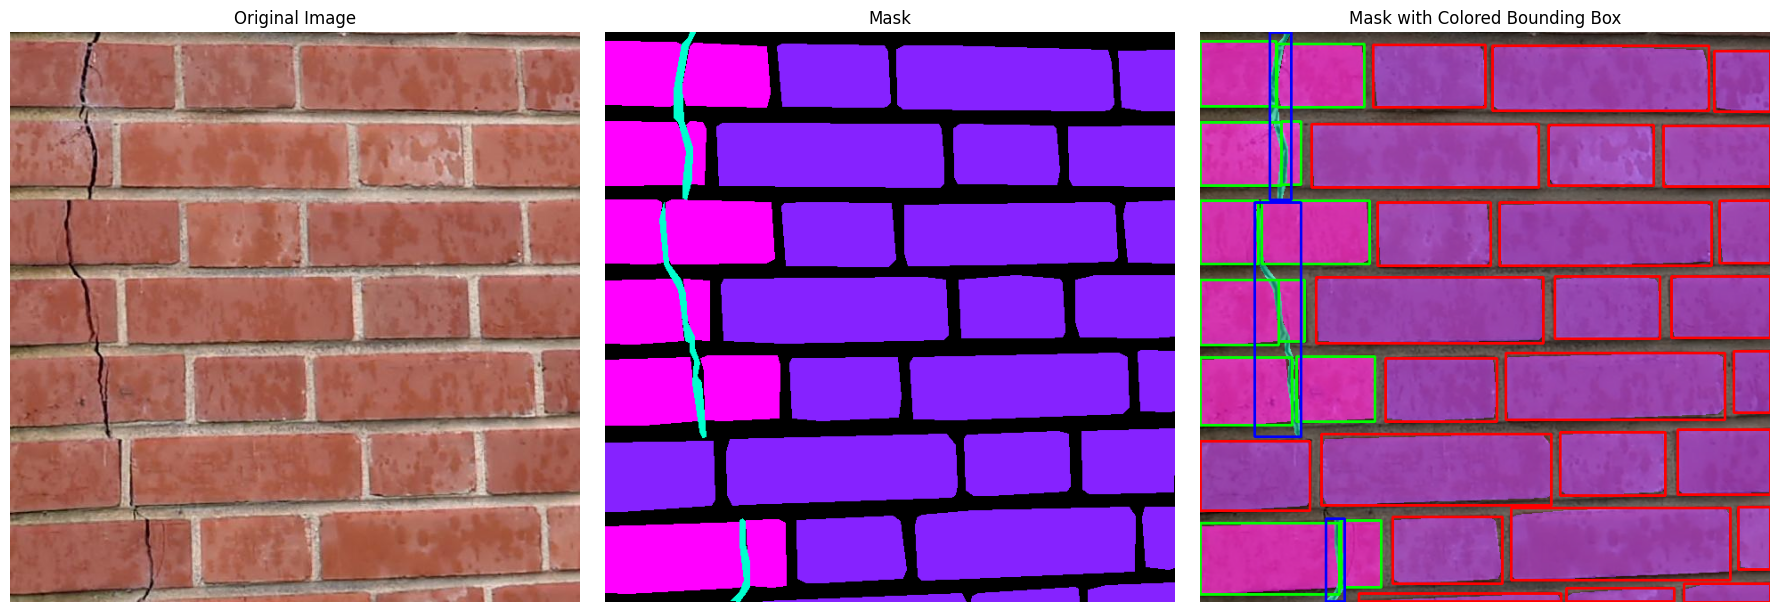

In [ ]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

image_path = '0793-2_jpg.rf.bc4d9d22246ab6cacf7336775d933b57.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

annotation_path = '_annotations.coco.json'
with open(annotation_path, 'r') as f:
    annotations = json.load(f)

image_id = None
for im in annotations['images']:
    if im['file_name'] == image_path:
        image_id = im['id']
        break      
        
height, width = image.shape[:2]

mask = np.zeros((height, width, 3), dtype=np.uint8)

for annotation in annotations['annotations']:
    if annotation['image_id'] == image_id:
        segmentation = annotation['segmentation']
        bbox = annotation['bbox']
        category_id = annotation['category_id']
        
        if category_id == 1:
            color = (134, 34, 255)
        elif category_id == 2:
            color = (255, 0, 255)
        else:
            color = (0, 255, 206)

        for segment in segmentation:
            points = np.array(segment).reshape(-1, 2).astype(np.int32)
            cv2.fillPoly(mask, [points], color=color)
        
masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

for annotation in annotations['annotations']:
    if annotation['image_id'] == image_id:
        bbox = annotation['bbox']
        x, y, w, h = bbox
        category_id = annotation['category_id']
        
        if category_id == 1:
            color = (255, 0, 0)
        elif category_id == 2:
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        
        cv2.rectangle(masked_image, (int(x), int(y)), (int(x + w), int(y + h)), color=color, thickness=2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(mask)
ax2.set_title('Mask')
ax2.axis('off')

ax3.imshow(masked_image)
ax3.set_title('Mask with Colored Bounding Box')
ax3.axis('off')

plt.tight_layout()
plt.show()

(-0.5, 639.5, 639.5, -0.5)

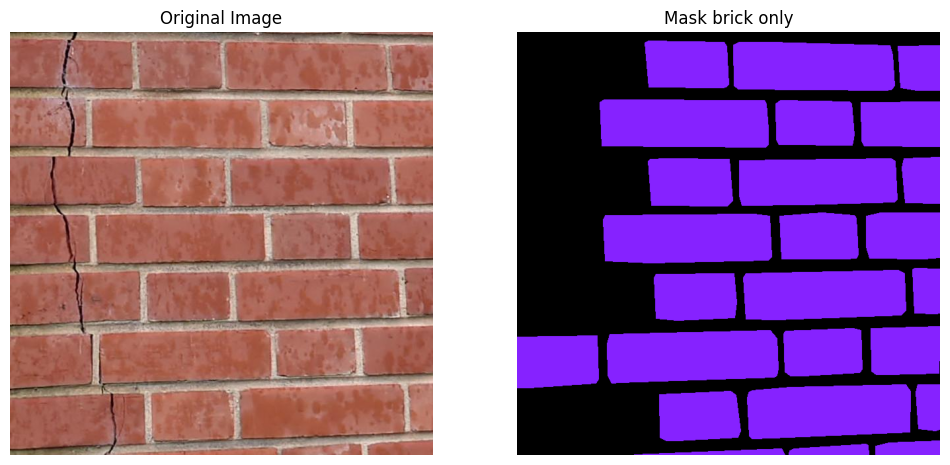

In [ ]:
mask_brick_only = np.zeros((height, width, 3), dtype=np.uint8)

for annotation in annotations['annotations']:
    if annotation['image_id'] == image_id:
        segmentation = annotation['segmentation']
        bbox = annotation['bbox']
        category_id = annotation['category_id']
        
        if category_id == 1:
            color = (134, 34, 255)
        else:
            color = (0, 0, 0)

        for segment in segmentation:
            points = np.array(segment).reshape(-1, 2).astype(np.int32)
            cv2.fillPoly(mask_brick_only, [points], color=color)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(mask_brick_only)
ax2.set_title('Mask brick only')
ax2.axis('off')

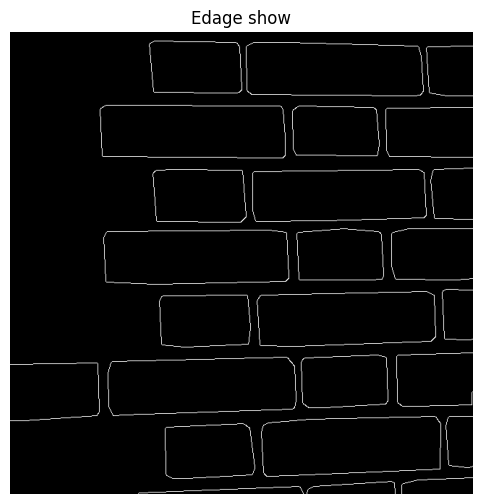

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

image_p = copy.copy(mask_brick_only)
gray_image = cv2.cvtColor(image_p, cv2.COLOR_RGB2GRAY)

edges = cv2.Canny(gray_image, 50, 150)

plt.figure(figsize=(12, 6))

plt.subplot()
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
plt.title('Edage show')
plt.axis('off')
plt.show()


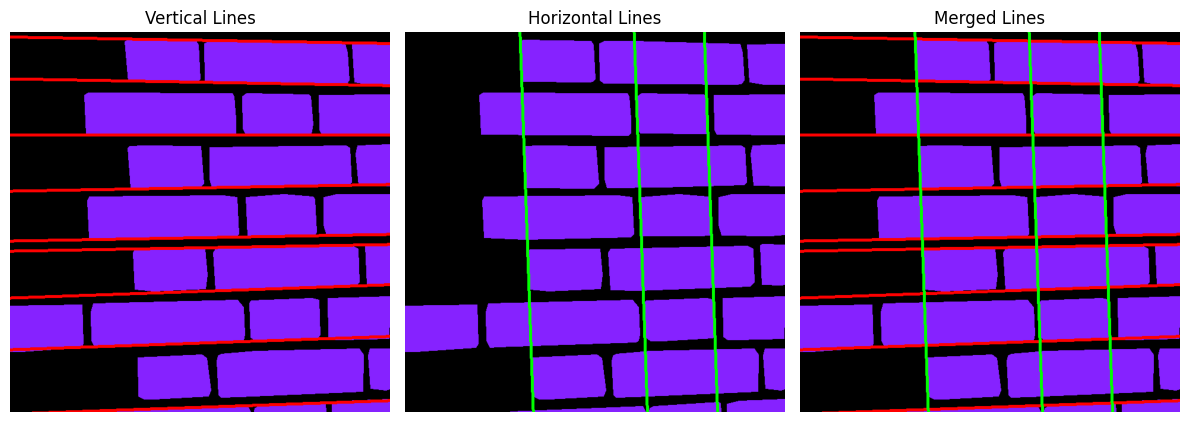

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

image_brick = copy.copy(mask_brick_only)

gray_image_brick = cv2.cvtColor(image_brick, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray_image_brick, 50, 150)

vertical_threshold = 170
horizontal_threshold = 106

vertical_lines = cv2.HoughLines(edges, 1, np.pi / 180, vertical_threshold, min_theta=np.pi / 4, max_theta=3 * np.pi / 4)
horizontal_lines = cv2.HoughLines(edges, 1, np.pi / 180, horizontal_threshold, min_theta=-np.pi / 4, max_theta=np.pi / 4)

vertical_lines_filtered = []
if vertical_lines is not None:
    for line in vertical_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        vertical_lines_filtered.append([(x0 + 1000 * (-b), y0 + 1000 * (a)), (x0 - 1000 * (-b), y0 - 1000 * (a))])

horizontal_lines_filtered = []
if horizontal_lines is not None:
    for line in horizontal_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        horizontal_lines_filtered.append([(x0 + 1000 * (-b), y0 + 1000 * (a)), (x0 - 1000 * (-b), y0 - 1000 * (a))])

vertical_image = image_brick.copy()
for line in vertical_lines_filtered:
    cv2.line(vertical_image, tuple(map(int, line[0])), tuple(map(int, line[1])), (255, 0, 0), 4)

horizontal_image = image_brick.copy()
for line in horizontal_lines_filtered:
    cv2.line(horizontal_image, tuple(map(int, line[0])), tuple(map(int, line[1])), (0, 255, 0), 4)

merged_image = vertical_image.copy()
for line in horizontal_lines_filtered:
    cv2.line(merged_image, tuple(map(int, line[0])), tuple(map(int, line[1])), (0, 255, 0), 4)

plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(vertical_image)
plt.title('Vertical Lines')
plt.axis('off')

plt.subplot(132)
plt.imshow(horizontal_image)
plt.title('Horizontal Lines')
plt.axis('off')

plt.subplot(133)
plt.imshow(merged_image)
plt.title('Merged Lines')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def find_farthest_lines(lines_list):
    max_distance = 0
    farthest_lines = []
    for i, line1 in enumerate(lines_list):
        for line2 in lines_list[i + 1:]:
            distance = np.linalg.norm(np.array(line1[0]) - np.array(line2[0]))
            if distance > max_distance:
                max_distance = distance
                farthest_lines = [line1, line2]
    return farthest_lines

farthest_vertical_lines = find_farthest_lines(vertical_lines_filtered)
farthest_horizontal_lines = find_farthest_lines(horizontal_lines_filtered)

vertical_image_2 = image_brick.copy()
for line in farthest_vertical_lines:
    cv2.line(vertical_image_2, tuple(map(int, line[0])), tuple(map(int, line[1])), (255, 0, 0), 4)

horizontal_image_2 = image_brick.copy()
for line in farthest_horizontal_lines:
    cv2.line(horizontal_image_2, tuple(map(int, line[0])), tuple(map(int, line[1])), (0, 255, 0), 4)

merged_image_2 = vertical_image_2.copy()
for line in farthest_horizontal_lines:
    cv2.line(merged_image_2, tuple(map(int, line[0])), tuple(map(int, line[1])), (0, 255, 0), 4)

plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(vertical_image_2)
plt.title('Vertical Lines')
plt.axis('off')

plt.subplot(132)
plt.imshow(horizontal_image_2)
plt.title('Horizontal Lines')
plt.axis('off')

plt.subplot(133)
plt.imshow(merged_image_2)
plt.title('Merged Lines')
plt.axis('off')

plt.tight_layout()
plt.show()

print(farthest_vertical_lines)
print(farthest_horizontal_lines)

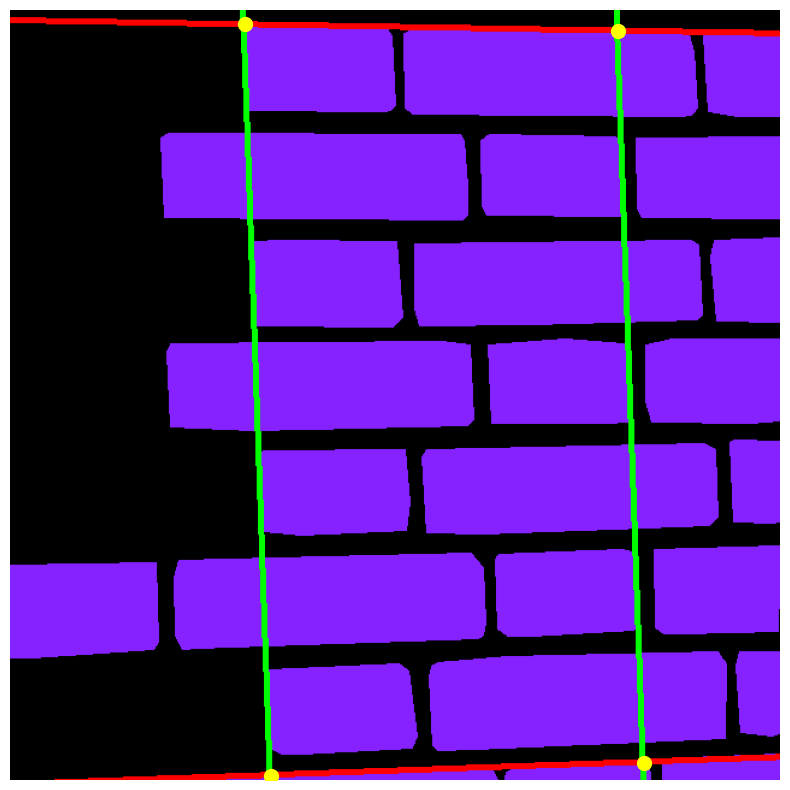

Intersection Point 1: (194.5162282177366, 11.396524293813346)
Intersection Point 2: (504.8943940617381, 16.814214700504643)
Intersection Point 3: (216.32222387422678, 635.8378350000884)
Intersection Point 4: (526.1333968421776, 625.0189921037523)


In [ ]:
def intersection(line1, line2):
    x1, y1 = line1[0]
    x2, y2 = line1[1]
    x3, y3 = line2[0]
    x4, y4 = line2[1]
    
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    if denom != 0:
        px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
        return px, py
    else:
        return None

intersection_points = []
for h_line in farthest_horizontal_lines:
    for v_line in farthest_vertical_lines:
        point = intersection(h_line, v_line)
        if point is not None:
            intersection_points.append(point)

plt.figure(figsize=(10, 10))

# for line in farthest_horizontal_lines:
#     plt.plot((line[0][0], line[1][0]), (line[0][1], line[1][1]), color='red',linewidth=3)

# for line in farthest_vertical_lines:
#     plt.plot((line[0][0], line[1][0]), (line[0][1], line[1][1]), color='green',linewidth=3)


for point in intersection_points:
    plt.plot(point[0], point[1], 'o',color='yellow',markersize=10)

plt.imshow(merged_image_2)
# plt.title('Intersection Points and Lines')
plt.axis('off')
plt.show()

intersection_points.sort(key=lambda x: (x[0], x[1]))

if intersection_points[1][1] > intersection_points[2][1]:
    intersection_points[1], intersection_points[2] = intersection_points[2], intersection_points[1]

for i, point in enumerate(intersection_points, 1):
    print(f"Intersection Point {i}: ({point[0]}, {point[1]})")

In [ ]:
import math

def calculate_side_length(points):
    longi = math.sqrt((points[0][0] - points[2][0])**2 + (points[0][1] - points[2][1])**2)
    trans = math.sqrt((points[2][0] - points[3][0])**2 + (points[2][1] - points[3][1])**2)

    return longi, trans

longi, trans = calculate_side_length(intersection_points)
print(longi)
print(trans)

624.8219362051411
310.000016544182


In [ ]:
x_o = intersection_points[0][0]+20
y_o = intersection_points[0][1]+20

dst = np.array([[x_o,y_o], [x_o+trans, y_o], [x_o, y_o+longi], [x_o+trans, y_o+longi]], dtype=np.float32)

src = np.array(intersection_points, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src, dst)

print("Perspective Transformation Matrix:")
print(perspective_matrix)

Perspective Transformation Matrix:
[[ 9.40125243e-01 -3.28298920e-02  2.85860343e+01]
 [-1.97862817e-02  9.85279311e-01  2.35138126e+01]
 [-8.24831838e-05  2.88049714e-06  1.00000000e+00]]


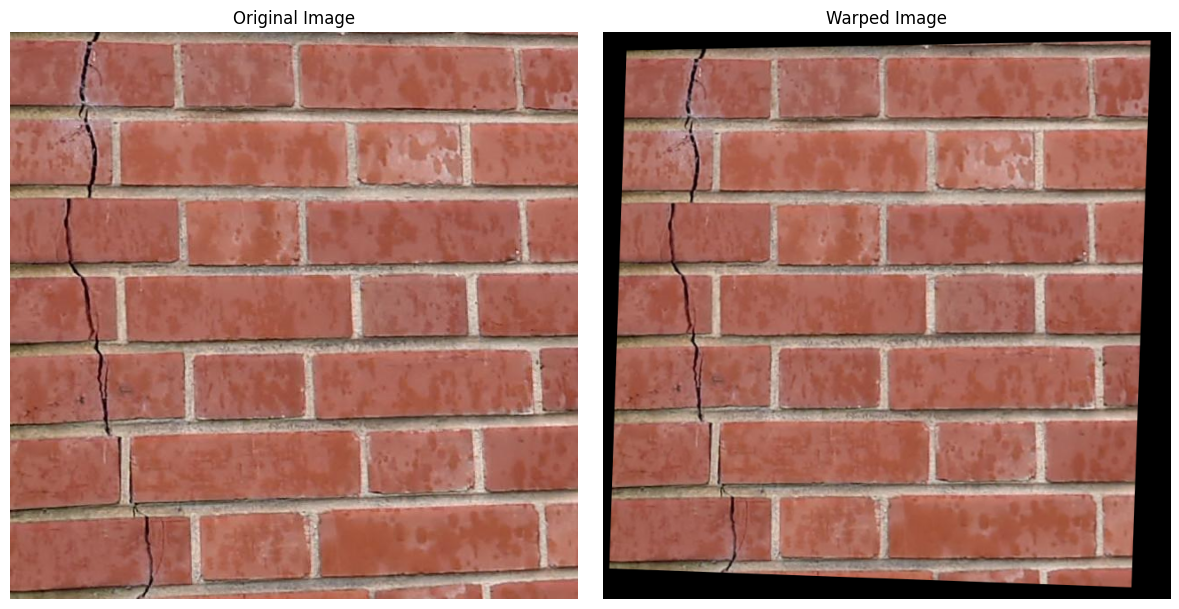

In [ ]:
image = cv2.imread(image_path)

original_image = image
height, width = 690,690
warped_image = cv2.warpPerspective(original_image, perspective_matrix, (width, height))

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.axis('off')

plt.tight_layout()
plt.show()

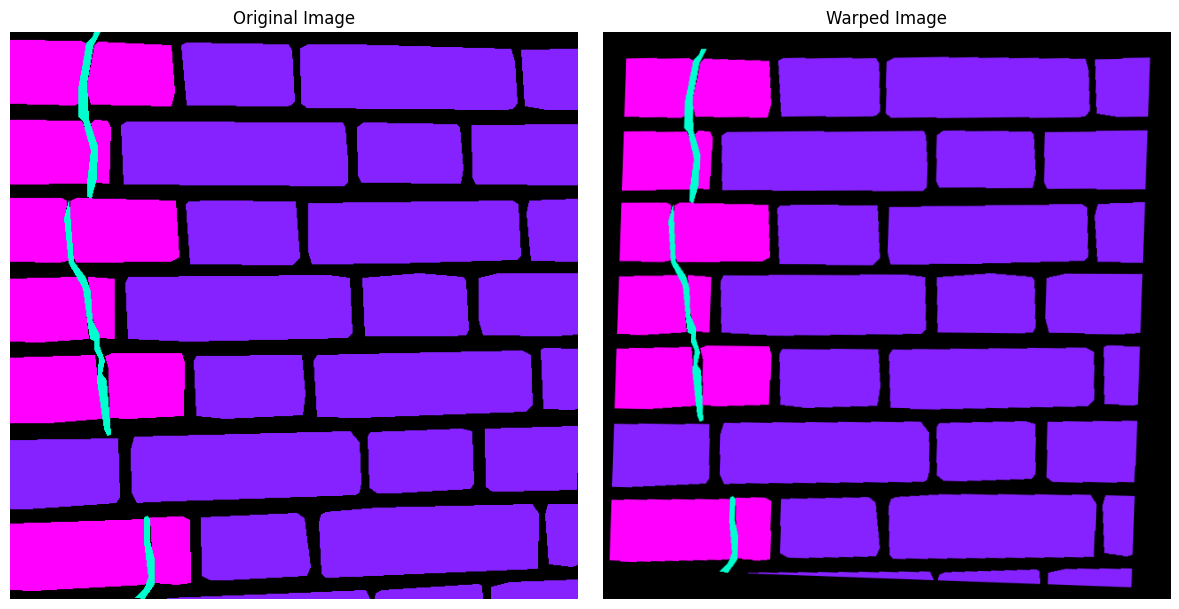

In [ ]:
original_image = mask

height, width = 690,690
warped_image = cv2.warpPerspective(original_image, perspective_matrix, (width, height))

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(warped_image)
plt.title('Warped Image')
plt.axis('off')

plt.tight_layout()
plt.show()


[585.3575, 33.622116, 400.80612, 31.71541, 352.76794, 32.562965, 344.66055, 36.753304, 343.50098, 99.50025, 349.301, 104.49202, 574.6131, 103.95847, 585.0054, 102.80795, 590.40753, 96.54816, 588.9981, 48.019745, 585.3575, 33.622116]
[664.6581, 32.25715, 597.77295, 34.442047, 599.64294, 99.53912, 625.5296, 103.38041, 662.1645, 102.964485, 664.6581, 32.25715]
[539.60455, 190.76016, 659.0489, 191.30756, 660.4915, 120.64713, 536.8327, 122.89829, 535.7785, 182.54956, 539.60455, 190.76016]
[412.80356, 121.06095, 405.58365, 126.218956, 404.65784, 182.16252, 408.4354, 189.26529, 521.153, 189.80905, 524.8036, 173.35617, 522.3837, 125.0942, 519.4148, 122.04214, 412.80356, 121.06095]
[581.2422, 210.2008, 347.53665, 213.8161, 345.6591, 268.4634, 349.1555, 282.64285, 442.56525, 281.96262, 584.0347, 278.3356, 588.32635, 274.2181, 587.31573, 214.31668, 581.2422, 210.2008]
[658.4626, 207.93173, 600.9559, 210.15196, 597.33105, 224.63129, 600.60284, 279.42264, 655.8983, 280.64352, 658.4626, 207.93173]
[

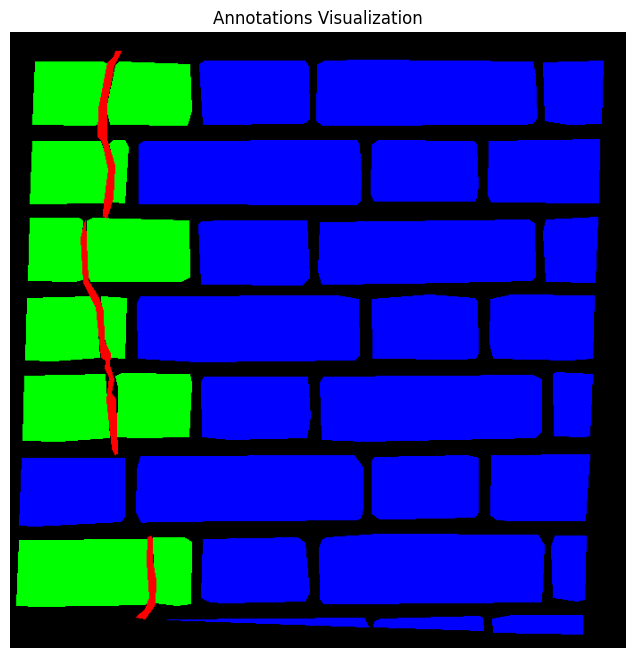

In [ ]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

annotation_path = '_annotations.coco.json'
with open(annotation_path, 'r') as f:
    annotations = json.load(f)

image_id = None
for im in annotations['images']:
    if im['file_name'] == image_path:
        image_id = im['id']
        break      

width = 690
height = 690    
        
mask = np.zeros((height, width, 3), dtype=np.uint8)

for annotation in annotations['annotations']:
    if annotation['image_id'] == image_id:
        segmentation = annotation['segmentation']
        category_id = annotation['category_id']
        
        points = np.array(segmentation).reshape(-1, 2).astype(np.int32)

        transformed_points = cv2.perspectiveTransform(np.array([points], dtype=np.float32), perspective_matrix)
        transformed_points = transformed_points[0]
        polygon = np.array(transformed_points, np.int32)
        polygon = polygon.reshape((-1, 1, 2))
        
        if category_id == 1:
            color = (255, 0, 0)
        elif category_id == 2:
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
    
        cv2.fillPoly(mask, [polygon], color=color)
        
        transformed_segmentations = []
        for point in transformed_points:
            transformed_segmentations.extend((point[0], point[1]))
    
        annotation['segmentation'] = transformed_segmentations
        print(annotation['segmentation'])

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Annotations Visualization')
plt.show()

In [ ]:
image_width = 690
image_height = 690
image_center = (image_width / 2, image_height / 2)

nearest_mask = None
min_distance = float('inf')

for annotation in annotations['annotations']:
    if annotation['image_id'] == image_id and annotation['category_id'] == 1:
        segmentation = annotation['segmentation']
    
        num_points = len(segmentation) // 2
        center_x = sum(segmentation[::2]) / num_points
        center_y = sum(segmentation[1::2]) / num_points

        distance = ((image_center[0] - center_x) ** 2 + (image_center[1] - center_y) ** 2) ** 0.5

        if distance < min_distance:
            min_distance = distance
            nearest_mask = segmentation

print(nearest_mask)

[367.65845, 295.88968, 146.01411, 296.824, 142.89395, 303.76968, 143.69673, 365.43356, 209.35402, 369.14832, 386.2293, 367.0565, 391.41864, 362.03323, 390.58105, 299.04614, 367.65845, 295.88968]


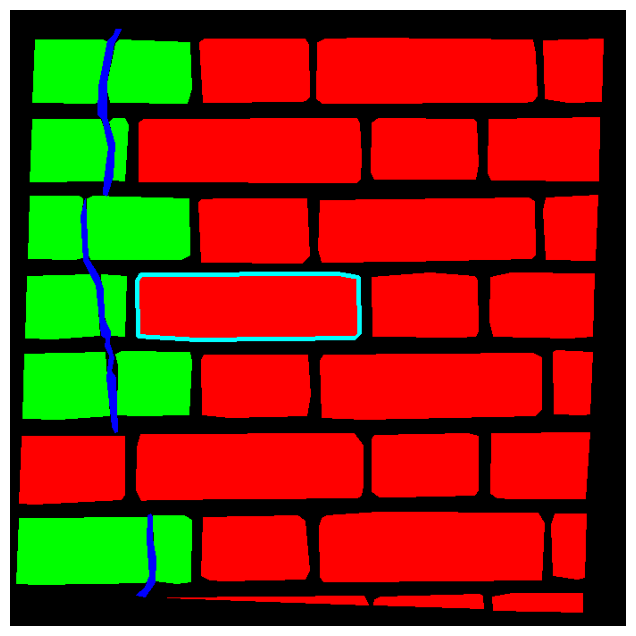

width: 73.28431701660156
height: 248.73048400878906


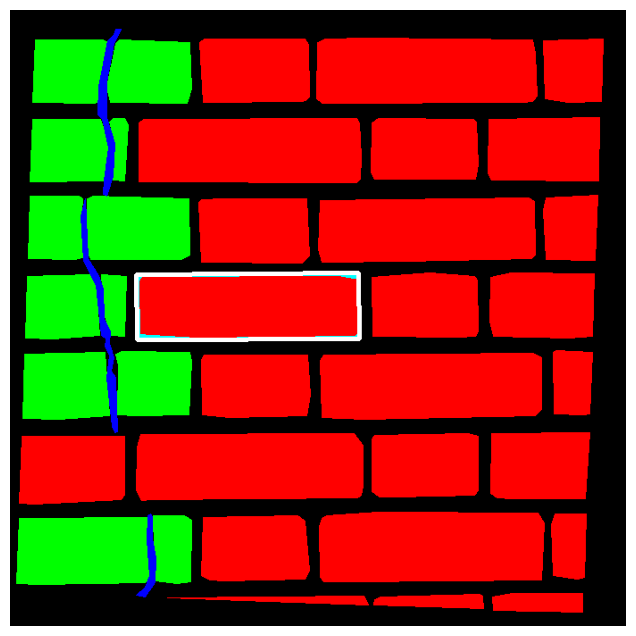

In [ ]:
contours = np.array(nearest_mask).reshape((-1, 1, 2)).astype(np.int32)

mask_c = copy.copy(mask)

cv2.drawContours(mask_c, [contours], -1, (0,255,255), 4)

plt.figure(figsize=(8, 8))
plt.imshow(mask_c, cmap='gray')
plt.axis('off')
plt.show()

rect = cv2.minAreaRect(contours)
width = rect[1][0]
height = rect[1][1]

print(f"width: {width}")
print(f"height: {height}")

box = cv2.boxPoints(rect)
box = np.intp(box)
cv2.drawContours(mask_c, [box], 0, (255,255,255), 4)

plt.figure(figsize=(8, 8))
plt.imshow(mask_c, cmap='gray')
plt.axis('off')
plt.show()